## **Plant Doctor**


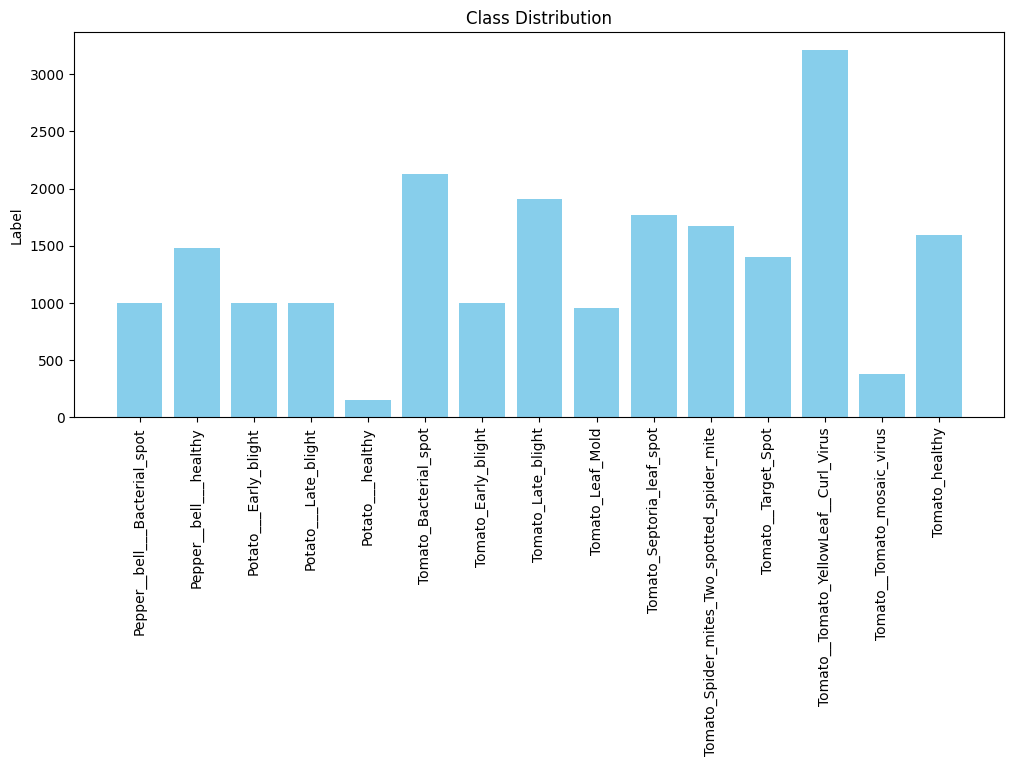

In [161]:
import os
import matplotlib.pyplot as plt
from pathlib import Path

path = Path("plantdisease/PlantVillage")

labels = os.listdir(path)
counts = [len(os.listdir(os.path.join(path, label))) for label in labels]

plt.figure(figsize=(12, 5))
plt.bar(labels, counts, color='skyblue')
plt.ylabel("Image count")
plt.ylabel("Label")
plt.title("Class Distribution")
plt.xticks(rotation=90)
plt.show()

#### Data Loading


In [162]:
from sklearn.model_selection import train_test_split
import pandas as pd

def load_data(path):
    data = []
    
    for p in path.iterdir():
        for image in p.iterdir():
            if image.suffix.lower() == ".jpg":
                data.append((image, image.parents[0].stem))
    
    return pd.DataFrame(data, columns=['path', 'label'])

df = load_data(path)

train_df, test_df = train_test_split(df, test_size=0.2)
train_df, valid_df = train_test_split(train_df, test_size=0.1)

print(train_df.shape)
print(valid_df.shape)
print(test_df.shape)

(14857, 2)
(1651, 2)
(4128, 2)


In [163]:
label_map = {label: i for i, label in enumerate(os.listdir(path))}
print(label_map)

{'Pepper__bell___Bacterial_spot': 0, 'Pepper__bell___healthy': 1, 'Potato___Early_blight': 2, 'Potato___Late_blight': 3, 'Potato___healthy': 4, 'Tomato_Bacterial_spot': 5, 'Tomato_Early_blight': 6, 'Tomato_Late_blight': 7, 'Tomato_Leaf_Mold': 8, 'Tomato_Septoria_leaf_spot': 9, 'Tomato_Spider_mites_Two_spotted_spider_mite': 10, 'Tomato__Target_Spot': 11, 'Tomato__Tomato_YellowLeaf__Curl_Virus': 12, 'Tomato__Tomato_mosaic_virus': 13, 'Tomato_healthy': 14}


In [164]:
from torch.utils import data
from PIL import Image
from torchvision.transforms.functional import pil_to_tensor, to_pil_image
import numpy as np

class Data(data.Dataset):
    def __init__(self, df, label_map, transforms=None):
        super().__init__()
        
        self.df = df

        self.label_map = label_map
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        sample = self.df.iloc[index]
        img = pil_to_tensor(Image.open(sample.path)) / 255
        
        if self.transforms is not None:
            img = img.permute(1, 2, 0).numpy()
            img = self.transforms(image=img)['image']
        
        return img, sample.label


train = Data(train_df[:500], label_map)
valid = Data(valid_df[:500], label_map)
test = Data(test_df[:500], label_map)

#### Data Normalization


In [165]:
import torch


def get_dataset_stats(ds):
    images = torch.stack([im[0] for im in ds])

    ds_mean = images.mean(dim=(0, 2, 3))
    ds_std = images.std(dim=(0, 2, 3))

    return ds_mean.tolist(), ds_std.tolist()


mean, std = get_dataset_stats(train)
print(f'Dataset stats\n  mean:\t {mean}\n  std:\t {std}' )


Dataset stats
  mean:	 [0.45669329166412354, 0.47397443652153015, 0.41119280457496643]
  std:	 [0.1938835233449936, 0.17255426943302155, 0.20779220759868622]


In [166]:
def ishow(img,
          cmap='viridis',
          title='',
          fig_size=(8,6),
          colorbar=False,
          interpolation='none'):
    ' Function `ishow` displays an image in a new window. '
    
    #extent = (0, img.shape[1], img.shape[0], 0)
    fig, ax = plt.subplots(figsize=fig_size)
    pcm = ax.imshow(img,
              #extent=extent,
              cmap=cmap,
              interpolation=interpolation)
    
    ax.set_frame_on(False)
    plt.title(title)
    plt.tight_layout()
    if colorbar:
        fig.colorbar(pcm, orientation='vertical')
    plt.show()

#### Data Augmentation


In [173]:
def show_augmentations(ds, idx, n_samples=3):
    figure = plt.figure(figsize=(8, 8))
    
    cols, rows = n_samples, n_samples
    sample_img, label = ds[idx]  
    
    for i in range(1, cols * rows + 1):
        img, _ = ds[idx]
        
        img_np = img.permute(1, 2, 0).cpu().detach().numpy()
        
        if img_np.min() < 0 or img_np.max() > 1:

            print(f'The image values were shifted to the range (0, 1). The original range is ({img.min():.04f}), {img.max():.04f})')
            img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())
            print(img_np.min(), img_np.max()) 
        figure.add_subplot(rows, cols, i)
        plt.axis("off")
        plt.imshow(img_np)
    
    plt.suptitle(f'sample no {idx}, label {label}')
    plt.tight_layout()
    plt.show()


In [202]:
import albumentations as A
from albumentations.pytorch import ToTensorV2


train_transform = A.Compose([
    A.Resize(64, 64),
    A.HorizontalFlip(p=.5),
    A.VerticalFlip(p=.5),
    A.Affine(rotate=(-180,180), p=.5),
    A.GaussianBlur(blur_limit=(3, 7), p=0.3),
    A.GaussNoise(p=0.3),
    A.CenterCrop(width=56, height=56),
    A.ElasticTransform(p=0.3),
    A.CLAHE(p=0.3),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=1.0),
    A.Normalize(
        mean=mean,
        std=std,
        normalization="image_per_channel"
    ),
    ToTensorV2()
])

valid_transform = A.Compose([
    A.Resize(64, 64),
    A.Normalize(
        mean=mean,
        std=std,
    ),
    ToTensorV2()
])

train = Data(train_df[:500], label_map, train_transform)
valid = Data(valid_df[:500], label_map, valid_transform)
test = Data(test_df[:500], label_map)

The image values were shifted to the range (0, 1). The original range is (-2.9145), 1.7916)
0.0 1.0
The image values were shifted to the range (0, 1). The original range is (-1.7442), 2.2906)
0.0 1.0
The image values were shifted to the range (0, 1). The original range is (-2.1017), 2.0201)
0.0 1.0
The image values were shifted to the range (0, 1). The original range is (-3.0127), 2.2227)
0.0 1.0
The image values were shifted to the range (0, 1). The original range is (-1.3572), 1.4834)
0.0 1.0
The image values were shifted to the range (0, 1). The original range is (-2.7086), 2.1123)
0.0 1.0
The image values were shifted to the range (0, 1). The original range is (-2.1582), 2.3466)
0.0 1.0
The image values were shifted to the range (0, 1). The original range is (-1.4203), 1.5656)
0.0 1.0
The image values were shifted to the range (0, 1). The original range is (-2.2870), 2.0216)
0.0 1.0


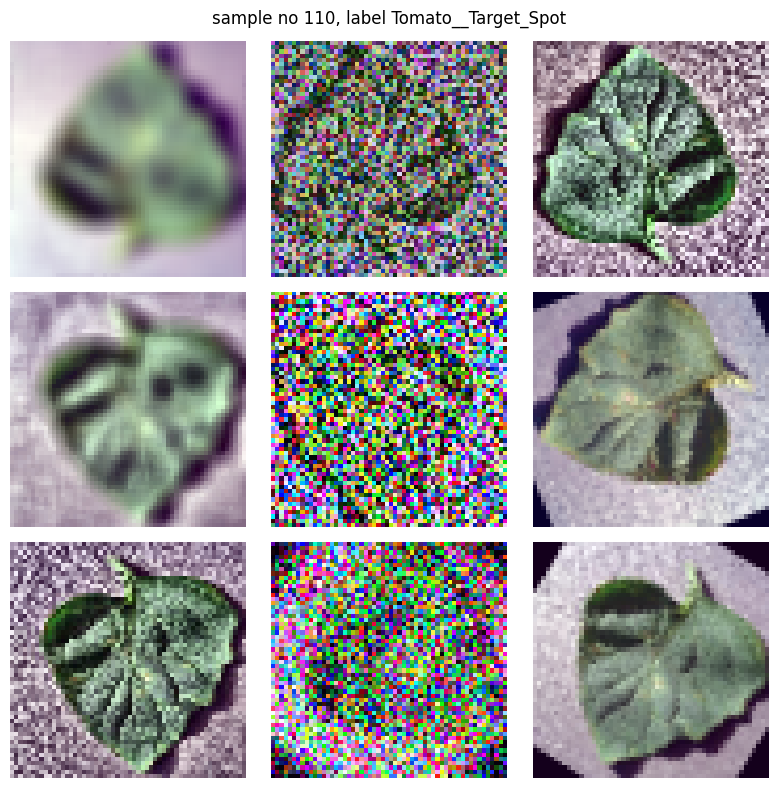

In [203]:
show_augmentations(train, 110)

In [188]:
from torch.utils.data import WeightedRandomSampler
from torch.utils.data import DataLoader

# rebalance the classes
class_counts = train_df['label'].value_counts()
class_weights = 1.0 / class_counts
sample_weights = train_df['label'].map(class_weights).values

sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

train_dataloader = DataLoader(train, batch_size=64, sampler=sampler)
test_dataloader = DataLoader(test, batch_size=64, shuffle=True)
val_dataloader = DataLoader(valid, batch_size=64, shuffle=True)